# Bayesian change point model

In [2]:
# import dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
  

## load the modules

In [3]:
from src.brent_change_point_analysis import (load_and_prepare_data,exploratory_analysis,bayesian_change_point_model,interpret_model)

## Load and prepare_data

In [4]:
 # Load and prepare data
price_data, event_data = load_and_prepare_data()
print("Data loaded and prepared successfully.")
#to print the first few rows of the data
print("Price Data:")
print(price_data.head())
print("Event Data:")
print(event_data.head())

    


Data loaded and prepared successfully.
Price Data:
            Brent_Price  Log_Returns
Date                                
1987-05-20        18.63          NaN
1987-05-21        18.45    -0.009709
1987-05-22        18.55     0.005405
1987-05-25        18.60     0.002692
1987-05-26        18.63     0.001612
Event Data:
                      Event_Name   Event_Type Start_Date  \
0             Russia-Ukraine War     Conflict 2022-02-24   
1      US-Iran Nuclear Deal Exit    Sanctions 2018-05-08   
2   OPEC+ Production Cuts (2020)  OPEC Policy 2020-04-12   
3    Middle East Conflict (2023)     Conflict 2023-10-07   
4  US Sanctions on Russia (2023)    Sanctions 2023-07-01   

                                         Description  \
0  Russian invasion of Ukraine led to a ~30% Bren...   
1  US withdrawal from Iran nuclear deal reduced I...   
2  OPEC+ agreed to cut production by 9.7 mb/d to ...   
3  Israel-Hamas conflict raised supply disruption...   
4  Sanctions on Russian oil exports l

## Exploratory Data Analysis

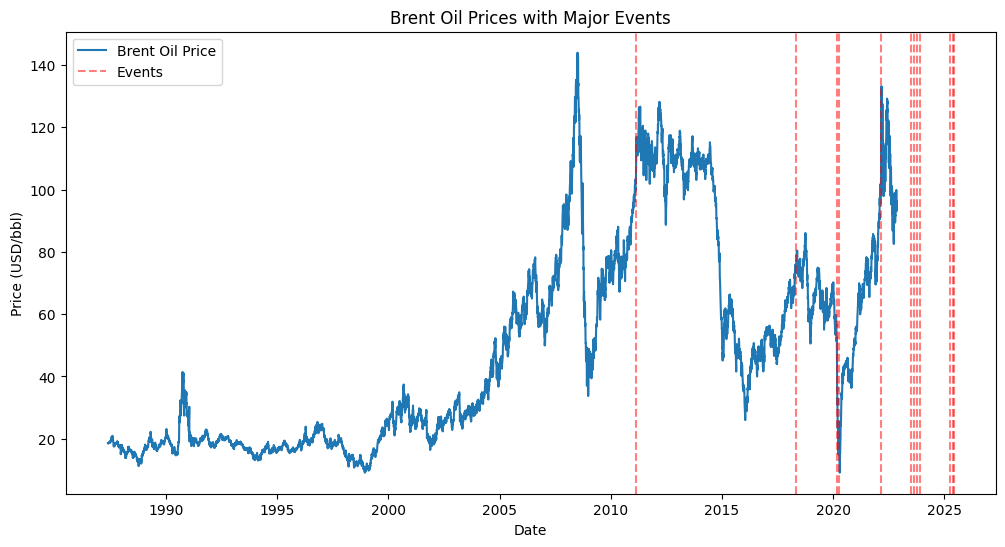

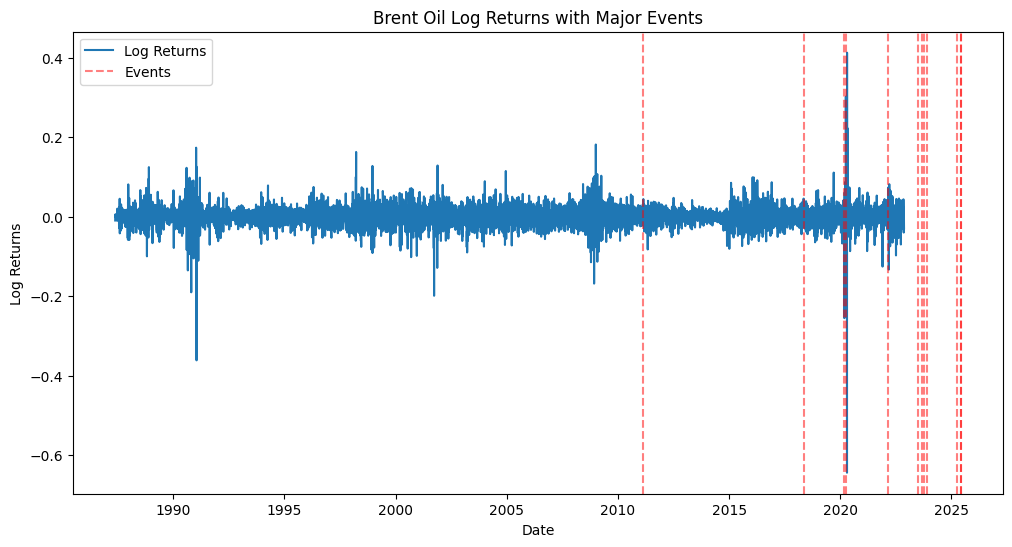

In [5]:
 # Perform EDA
exploratory_analysis(price_data, event_data)
    


## Bayesian change point model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 17202 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Model Summary:
           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    4519.891  3.188  4513.000  4525.000      0.124    0.098     672.0   
mu_1     21.404  0.276    20.867    21.892      0.004    0.004    4665.0   
mu_2     75.431  0.282    74.938    75.984      0.004    0.004    4626.0   
sigma    18.578  0.137    18.326    18.846      0.002    0.002    4902.0   

       ess_tail  r_hat  
tau       673.0   1.01  
mu_1     3047.0   1.00  
mu_2     2553.0   1.00  
sigma    2795.0   1.00  


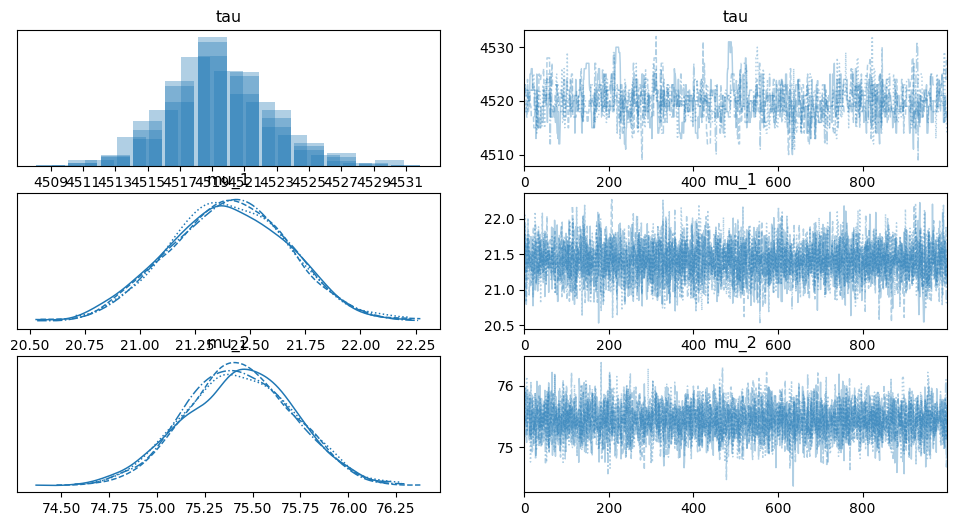

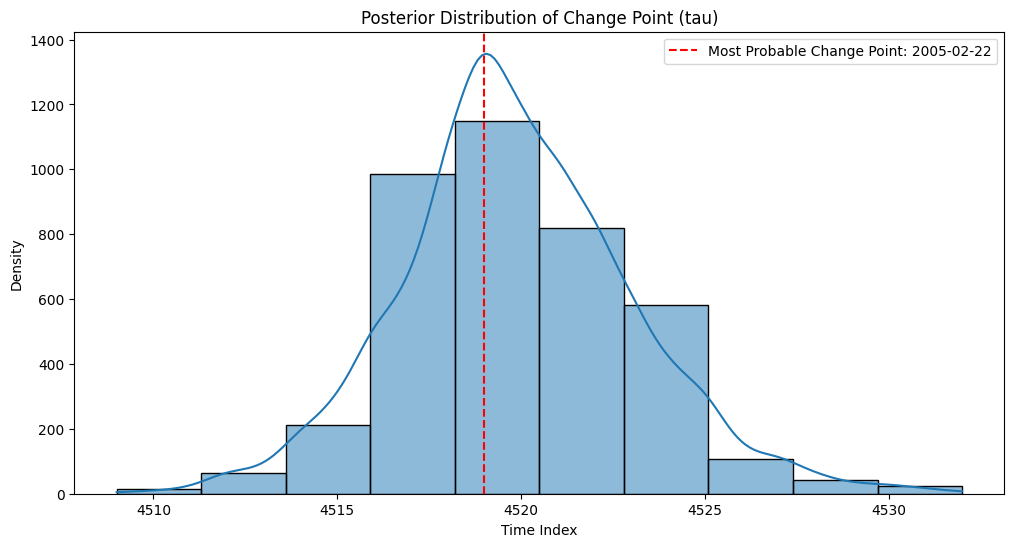


Change Point Insights:
Change point detected on 2005-02-22, but no events found within 1-week window. Average price shifted from $21.40 to $75.43, an increase of 252.42%.


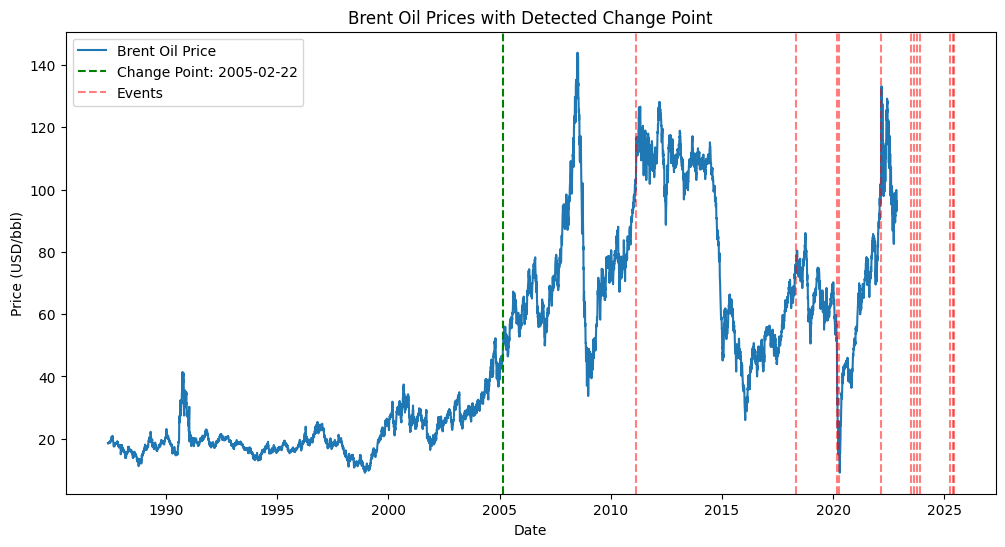


Results saved to 'change_point_results.csv'


In [6]:
    # Run Bayesian change point model
try:
        trace, idx = bayesian_change_point_model(price_data)
        
        # Interpret results
        change_point_date, insights, mu_1_mean, mu_2_mean, price_change, associated_events = interpret_model(trace, price_data, event_data)
        
        # Print insights
        print("\nChange Point Insights:")
        for insight in insights:
            print(insight)
        
        # Plot price series with change point
        plt.figure(figsize=(12, 6))
        plt.plot(price_data.index, price_data['Brent_Price'], label='Brent Oil Price')
        plt.axvline(x=change_point_date, color='g', linestyle='--', label=f'Change Point: {change_point_date.date()}')
        for event_date in event_data['Start_Date']:
            plt.axvline(x=event_date, color='r', linestyle='--', alpha=0.5, label='Events' if event_date == event_data['Start_Date'].iloc[0] else '')
        plt.title('Brent Oil Prices with Detected Change Point')
        plt.xlabel('Date')
        plt.ylabel('Price (USD/bbl)')
        plt.legend()
        plt.savefig('brent_change_point.png')
        plt.show()
        
        # Save results
        results = pd.DataFrame({
            'Change_Point_Date': [change_point_date],
            'Mean_Before': [mu_1_mean],
            'Mean_After': [mu_2_mean],
            'Price_Change_Percent': [price_change],
            'Associated_Events': [', '.join(associated_events['Event_Name'].tolist()) if not associated_events.empty else 'None']
        })
        results.to_csv('change_point_results.csv', index=False)
        print("\nResults saved to 'change_point_results.csv'")
    
except Exception as e:
        print(f"Error in change point modeling: {e}")
        print("Note: The sample data is too short (10 days in 1987) for reliable change point detection. "
              "Consider providing a longer time series (e.g., from EIA) covering 2010–2025 to align with events.")
